## Data Import

In [1]:
# If the 'datasets' package is not installed, remove the comment symbol below to install it
# !pip install datasets
from datasets import load_dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Activation, Flatten, SimpleRNN, LSTM, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from collections import Counter

/root/miniconda3/envs/myconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-09 21:30:14.025971: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 21:30:14.080288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-09 21:30:14.978000: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

In [2]:
# Try to connect to Hugging Face and load the dataset
# ds = load_dataset("larryvrh/Chinese-Poems")
# print(ds)

In [3]:
# If the connection fails, use a local dataset
dataset_path = "/root/train-00000-of-00001.parquet"
ds = load_dataset("parquet", data_files=dataset_path)

print(ds)

DatasetDict({
    train: Dataset({
        features: ['dynasty', 'author', 'title', 'content'],
        num_rows: 217561
    })
})


## Data Understanding

In [4]:
# Check the dataset statistics
stats = {
    "Number of Rows": len(ds['train']),
    "Number of Columns": len(ds['train'].column_names),
    "Columns": ds['train'].column_names,
    "Sample Data": ds['train'][:5]
}

# Assess data quality (null or empty values)
empty_values = {
    column: sum(1 for value in ds['train'][column] if not value.strip())
    for column in ds['train'].column_names
}

# Unique values in the 'dynasty' column
dynasty_stats = {
    "Unique Dynasties": len(set(ds['train']['dynasty'])),
    "Dynasty Distribution": {dynasty: ds['train']['dynasty'].count(dynasty) for dynasty in set(ds['train']['dynasty'])}
}

# Dataset Insights
sample_lengths = {
    "Content Lengths": [len(item) for item in ds['train']['content'][:5]],
    "Longest Content Length": max(len(item) for item in ds['train']['content']),
    "Shortest Content Length": min(len(item) for item in ds['train']['content']),
}


In [5]:
print("Dataset Statistics:", stats)
print("Empty Values:", empty_values)
print("Dynasty Stats:", dynasty_stats)
print("Content Length Insights:", sample_lengths)

Dataset Statistics: {'Number of Rows': 217561, 'Number of Columns': 4, 'Columns': ['dynasty', 'author', 'title', 'content'], 'Sample Data': {'dynasty': ['宋代', '宋代', '宋代', '清代', '宋代'], 'author': ['李弥逊', '刘克庄', '赵蕃', '彭绩', '刘克庄'], 'title': ['题大儒寮小阁', '古墓', '从礼载酒要余及明叔游合普六首', '戏简族子葆元', '喜雨五首'], 'content': ['青鞋踏尽剑鋩山，借枕僧房落照间。\n高屋凭虚听泉语，岭云应似我身闲。', '龟趺但见碑讹缺，马鬣安知葬旧新。\n想见若敖求食鬼，亦羞东郭乞墦人。', '尘埃老矣未收身，每对山林强自亲。\n诗纵满囊惭李贺，笔虽成冢愧藏真。', '观君如有得，意色尚孩重。身隐南园内，家贫五字中。新年从幼识，旧姓此生同。何不时来过，门前道路通。', '昕朝避黄屋，露祷动苍穹。\n野老安知帝，豚蹄赛社公。']}}
Empty Values: {'dynasty': 0, 'author': 0, 'title': 1, 'content': 0}
Dynasty Stats: {'Unique Dynasties': 16, 'Dynasty Distribution': {'元代': 9714, '唐代': 34527, '明代': 17661, '近代': 7997, '宋代': 104244, '五代': 173, '清代': 32014, '当代': 5601, '金朝': 1163, '先秦': 462, '现代': 123, '南北朝': 2292, '两汉': 319, '未知': 107, '隋代': 198, '魏晋': 966}}
Content Length Insights: {'Content Lengths': [33, 33, 33, 48, 25], 'Longest Content Length': 20111, 'Shortest Content Length': 5}


In [6]:
# Categorize poems based on their lengths
categories = {
    "100-200": [poem for poem in ds['train'] if 100 < len(poem['content']) <= 200],
    "200-500": [poem for poem in ds['train'] if 200 < len(poem['content']) <= 500],
    "500-1000": [poem for poem in ds['train'] if 500 < len(poem['content']) <= 1000],
    ">1000": [poem for poem in ds['train'] if len(poem['content']) > 1000],
}

# Count the number of poems in each category
category_counts = {key: len(value) for key, value in categories.items()}

# Create a DataFrame for display
category_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['Number of Poems'])
category_df.index.name = "Length Range"

# Display the result
print(category_df)


              Number of Poems
Length Range                 
100-200                 36456
200-500                  5751
500-1000                  685
>1000                     298


In [7]:
# Filter out poems where the title is empty and poems where the content length is greater than 200
filtered_poems = [
    poem for poem in ds['train'] if poem['title'].strip() and len(poem['content']) <= 100
]

# Convert the filtered poems to a DataFrame for display
filtered_poems_df = pd.DataFrame(filtered_poems)

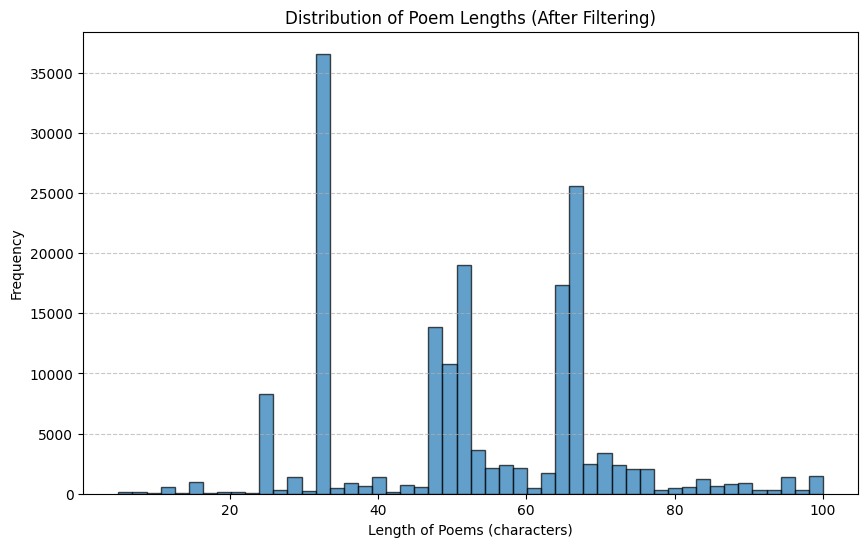

In [8]:
# Calculate the lengths of the filtered poems
filtered_lengths = [len(poem['content']) for poem in filtered_poems]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Poem Lengths (After Filtering)')
plt.xlabel('Length of Poems (characters)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## STEP 1: LOGIT

In [9]:
modified_poems = [
    {"content": "aaa" + re.sub(r"[^\w\s]", "", poem['content']).replace("\n", "").strip()}
    for poem in filtered_poems
]

# Print the modified data for the first few rows
for i in range(3):
    print(modified_poems[i])

# Convert to DataFrame for better display or further processing
modified_poems_df = pd.DataFrame(modified_poems)

# Display the first few rows of the DataFrame
print(modified_poems_df.head())

{'content': 'aaa青鞋踏尽剑鋩山借枕僧房落照间高屋凭虚听泉语岭云应似我身闲'}
{'content': 'aaa龟趺但见碑讹缺马鬣安知葬旧新想见若敖求食鬼亦羞东郭乞墦人'}
{'content': 'aaa尘埃老矣未收身每对山林强自亲诗纵满囊惭李贺笔虽成冢愧藏真'}
                                       content
0              aaa青鞋踏尽剑鋩山借枕僧房落照间高屋凭虚听泉语岭云应似我身闲
1              aaa龟趺但见碑讹缺马鬣安知葬旧新想见若敖求食鬼亦羞东郭乞墦人
2              aaa尘埃老矣未收身每对山林强自亲诗纵满囊惭李贺笔虽成冢愧藏真
3  aaa观君如有得意色尚孩重身隐南园内家贫五字中新年从幼识旧姓此生同何不时来过门前道路通
4                      aaa昕朝避黄屋露祷动苍穹野老安知帝豚蹄赛社公


In [10]:
# If the training memory is insufficient, you can uncomment the following code to reduce the training data.
import random
modified_poems = random.sample(modified_poems, len(modified_poems) // 2)

In [11]:
XY = []

# Iterate through the processed poem content
for poem in modified_poems:
    content = poem['content']  
    for i in range(len(content) - 3):
        x1 = content[i]
        x2 = content[i + 1]
        x3 = content[i + 2]
        y = content[i + 3]
        XY.append([x1, x2, x3, y])

# Print sample data
print("Training_data:")
print(["X1", "X2", "X3", "Y"])
for i in range(10): 
    print(XY[i])

Training_data:
['X1', 'X2', 'X3', 'Y']
['a', 'a', 'a', '胡']
['a', 'a', '胡', '靴']
['a', '胡', '靴', '短']
['胡', '靴', '短', '靿']
['靴', '短', '靿', '格']
['短', '靿', '格', '粗']
['靿', '格', '粗', '疏']
['格', '粗', '疏', '古']
['粗', '疏', '古', '雅']
['疏', '古', '雅', '无']


In [12]:
# Prepare data (Assuming XY is the previously generated sliding window data)
# XY is in the format [["X1", "X2", "X3", "Y"], ...]
text_data = ["".join(item) for item in XY]  

# Initialize Tokenizer
tokenizer = Tokenizer(char_level=True)  # Set char_level=True to process at the character level
tokenizer.fit_on_texts(text_data) 

# Print the vocabulary
# print("Vocabulary:")
# print(tokenizer.word_index)

# Calculate the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print("\n vocab size:", vocab_size)

# Encode XY into digits
XY_digit = np.array(tokenizer.texts_to_sequences(text_data))  
X_digit = XY_digit[:, :3]  
Y_digit = XY_digit[:, 3]   

# Print sample data
print("\n sample data:")
for i in range(10):  
    print(f"{str(X_digit[i]):<30}\t{Y_digit[i]}")



 vocab size: 9137

 sample data:
[1 1 1]                       	706
[  1   1 706]                 	3034
[   1  706 3034]              	490
[ 706 3034  490]              	6501
[3034  490 6501]              	1884
[ 490 6501 1884]              	1941
[6501 1884 1941]              	249
[1884 1941  249]              	126
[1941  249  126]              	1175
[ 249  126 1175]              	6


In [13]:
# Count word frequencies and keep high-frequency words
word_counts = Counter(Y_digit)
filtered_words = {word: idx for idx, (word, count) in enumerate(word_counts.items()) if count >= 100}  

# Update Y_digit and calculate the new vocab_size
Y_digit = [word for word in Y_digit if word in filtered_words]
vocab_size = len(filtered_words) + 1
# num_classes = max(Y_digit) + 1

In [14]:
# Clear GPU memory
K.clear_session()
tf.config.experimental.reset_memory_stats('/GPU:0')

2024-12-09 21:31:44.699587: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78933 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:15:00.0, compute capability: 8.0


In [15]:
filtered_indices = [i for i, idx in enumerate(Y_digit) if idx < vocab_size]

X_digit = [X_digit[i] for i in filtered_indices]
Y_digit = [Y_digit[i] for i in filtered_indices]

# Check lengths again
print("Filtered Length of X_digit:", len(X_digit))
print("Filtered Length of Y_digit:", len(Y_digit))

Filtered Length of X_digit: 3668475
Filtered Length of Y_digit: 3668475


In [16]:
hidden_size = 256

# Define the input layer
inp = Input(shape=(3,))
x = Embedding(vocab_size, hidden_size)(inp)
x = Flatten()(x)
x = Dense(vocab_size, activation='softmax')(x)  # Add softmax here
pred = x


# Define the model
model = Model(inp, pred)
model.summary()

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Define the generator class
class DataGenerator(Sequence):
    def __init__(self, X, Y, batch_size, num_classes):
        self.X = np.array(X)  
        self.Y = np.array(Y)  
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.indices = np.arange(len(self.X))
        
    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))
    
    def __getitem__(self, index):
        start = index * self.batch_size
        end = start + self.batch_size
        batch_indices = self.indices[start:end]

        X_batch = self.X[batch_indices]
        Y_batch = self.Y[batch_indices]

        Y_batch_onehot = to_categorical(Y_batch, num_classes=self.num_classes)
        return X_batch, Y_batch_onehot

# Prepare data
num_classes = vocab_size  

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X_digit, Y_digit, test_size=0.2, random_state=0
)

batch_size = 1024
train_generator = DataGenerator(X_train, Y_train, batch_size, num_classes)
test_generator = DataGenerator(X_test, Y_test, batch_size, num_classes)

# Train the model
model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 embedding (Embedding)       (None, 3, 256)            727808    
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 2843)              2186267   
                                                                 
Total params: 2914075 (11.12 MB)
Trainable params: 2914075 (11.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20


2024-12-09 21:31:55.546393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-12-09 21:31:55.551657: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6c2800eba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-09 21:31:55.551723: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-12-09 21:31:55.566247: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-09 21:31:55.768242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2024-12-09 21:31:55.952039: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

2866/2866 [==============================] - 67s 23ms/step - loss: 7.0797 - accuracy: 0.0095 - val_loss: 7.0591 - val_accuracy: 0.0089
Epoch 2/20
2866/2866 [==============================] - 36s 13ms/step - loss: 7.0070 - accuracy: 0.0103 - val_loss: 7.0798 - val_accuracy: 0.0090
Epoch 3/20
2866/2866 [==============================] - 34s 12ms/step - loss: 6.9069 - accuracy: 0.0110 - val_loss: 7.1390 - val_accuracy: 0.0085
Epoch 4/20
2866/2866 [==============================] - 36s 13ms/step - loss: 6.8090 - accuracy: 0.0115 - val_loss: 7.2123 - val_accuracy: 0.0083
Epoch 5/20
2866/2866 [==============================] - 36s 12ms/step - loss: 6.7355 - accuracy: 0.0117 - val_loss: 7.2805 - val_accuracy: 0.0075
Epoch 6/20
2866/2866 [==============================] - 35s 12ms/step - loss: 6.6835 - accuracy: 0.0119 - val_loss: 7.3381 - val_accuracy: 0.0075
Epoch 7/20
2866/2866 [==============================] - 37s 13ms/step - loss: 6.6463 - accuracy: 0.0123 - val_loss: 7.3849 - val_accura

In [17]:
# Sample text, predict the next character
sample_text = ['床', '前', '明']
print("Sample text:", sample_text)

sample_index = tokenizer.texts_to_sequences(sample_text)
print("Index:", sample_index)

word_prob = model.predict(np.array(sample_index).reshape(1, 3))
predicted_index = word_prob.argmax()
predicted_word = tokenizer.index_word[predicted_index]

print("next word:", predicted_word, "，max probability:", word_prob.max())


Sample text: ['床', '前', '明']
Index: [[620], [73], [46]]
1/1 [==============================] - 0s 89ms/step
next word: 人 ，max probability: 0.013467364


In [18]:
poem_incomplete = 'aaa密****歇****根****湖****'  # Incomplete poem
poem_index = []  
poem_text = ''  

for i in range(len(poem_incomplete)):
    current_word = poem_incomplete[i]
    if current_word != '*':  
        index = tokenizer.word_index.get(current_word, 0)  
    else:
        x = np.array(poem_index[-3:]).reshape(1, 3)
        y = model.predict(x)
        index = y.argmax()  # Find the index with the highest probability
        current_word = tokenizer.index_word.get(index, '')  
    
    poem_index.append(index) 
    poem_text += current_word  

# Display the generated poem
poem_text = poem_text[3:]  
print("Generated poem:")
print(poem_text[:5])
print(poem_text[5:10])
print(poem_text[10:15])
print(poem_text[15:20])


1/1 [==============================] - 0s 20ms/step
Generated poem:
密人风风不
歇一不不不
根人不不不
湖人不不不


## STEP 2: RNN

In [19]:
poems = filtered_poems_df['content'].tolist()
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)  

poems = [remove_punctuation(poem) for poem in poems]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(poems)

poems_digit = tokenizer.texts_to_sequences(poems)
# vocab_size = len(tokenizer.word_index) + 1

# Pad the sequences to ensure uniform length (a maximum length can be set as maxlen)
maxlen = 49  
poems_padded = pad_sequences(poems_digit, maxlen=maxlen, padding='post')

print("Vocabulary size:", vocab_size)  

Vocabulary size: 2843


In [20]:
word_counts = Counter([word for poem in poems_digit for word in poem])

In [21]:
# Pad filtered sequences (before DataGenerator)
# max_len = 49
# poems_padded = pad_sequences(filtered_sequences, maxlen=max_len, padding='post')

# Align X and Y
X = poems_padded[:, :-1]  # First n-1 tokens as input
Y = poems_padded[:, 1:]   # Last n-1 tokens as target

# Convert Y to NumPy integer array
Y = np.array(Y, dtype=np.int32)  # Ensure Y is a NumPy array
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)


Shape of X: (174371, 48)
Shape of Y: (174371, 48)


In [22]:
# Clear GPU memory
K.clear_session()
tf.config.experimental.reset_memory_stats('/GPU:0')

In [23]:
# Define spatial dimensions
embedding_size = 64
hidden_size = 128 

class DataGenerator(Sequence):
    def __init__(self, X, Y, batch_size, vocab_size):
        self.X = X
        self.Y = Y  
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.indices = np.arange(len(self.X))

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = start + self.batch_size
        batch_indices = self.indices[start:end]

        X_batch = self.X[batch_indices]
        Y_batch = self.Y[batch_indices]
        Y_batch_onehot = np.array([self.to_onehot(y, self.vocab_size) for y in Y_batch])
        return X_batch, Y_batch_onehot
    def to_onehot(self, y, vocab_size):
        #y = np.asarray(y, dtype=np.int32).flatten()
        one_hot = np.zeros((y.shape[0], vocab_size), dtype=np.float32)
        for i, token in enumerate(y):
            if 0 <= token < vocab_size:  
                one_hot[i, token] = 1.0
        return one_hot

# Split training and validation sets
Y = np.array(Y, dtype=np.int32)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create generators
batch_size = 64
train_generator = DataGenerator(X_train, Y_train, batch_size, vocab_size)
val_generator = DataGenerator(X_val, Y_val, batch_size, vocab_size)
X_batch, Y_batch_onehot = train_generator[0]
print("Shape of X_batch:", X_batch.shape)
print("Shape of Y_batch_onehot:", Y_batch_onehot.shape)

# Model construction
inputs = Input(shape=(X.shape[1],))  
x = Embedding(input_dim=vocab_size, output_dim=embedding_size, mask_zero=True)(inputs)
# x = SimpleRNN(hidden_size, return_sequences=True)(x)
x = SimpleRNN(hidden_size, return_sequences=True, dropout=0.2)(x)
outputs = Dense(vocab_size, activation='softmax')(x)

# Compile the model
model = Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

# Train using the generator
history = model.fit(train_generator, validation_data=val_generator, epochs=5)

Shape of X_batch: (64, 48)
Shape of Y_batch_onehot: (64, 48, 2843)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48)]              0         
                                                                 
 embedding (Embedding)       (None, 48, 64)            181952    
                                                                 
 simple_rnn (SimpleRNN)      (None, 48, 128)           24704     
                                                                 
 dense (Dense)               (None, 48, 2843)          366747    
                                                                 
Total params: 573403 (2.19 MB)
Trainable params: 573403 (2.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
2180/2180 [==============================] - 192s 87ms/step - loss: 0.6064 - acc

In [24]:
from collections import Counter
print("Training label distribution:", Counter(Y_train.flatten()))
print("Validation label distribution:", Counter(Y_val.flatten()))

Training label distribution: Counter({0: 6530084, 1: 23, 2: 12, 4: 9, 5: 8, 3: 8, 6: 7, 8: 6, 10: 6, 9: 4, 23: 4, 24: 4, 25: 4, 26: 4, 14: 4, 12: 4, 7: 4, 75: 3, 68: 3, 69: 3, 70: 3, 131: 3, 132: 3, 95: 3, 45: 3, 113: 3, 18: 3, 183: 3, 168: 3, 135: 3, 136: 3, 137: 3, 77: 3, 78: 3, 79: 3, 51: 3, 108: 3, 109: 3, 110: 3, 138: 3, 49: 3, 28: 3, 29: 3, 30: 3, 151: 3, 152: 3, 153: 3, 154: 3, 172: 3, 173: 3, 174: 3, 50: 3, 31: 3, 32: 3, 33: 3, 91: 3, 126: 3, 19: 3, 20: 3, 21: 3, 37: 3, 122: 3, 115: 3, 177: 3, 178: 3, 179: 3, 180: 3, 54: 3, 55: 3, 81: 3, 53: 3, 155: 3, 156: 3, 3966: 2, 4221: 2, 1946: 2, 59: 2, 4121: 2, 362: 2, 3277: 2, 3158: 2, 2831: 2, 2832: 2, 2833: 2, 3118: 2, 4650: 2, 1281: 2, 1864: 2, 1865: 2, 1866: 2, 4555: 2, 2973: 2, 2974: 2, 4587: 2, 4588: 2, 4589: 2, 1051: 2, 3447: 2, 3448: 2, 3449: 2, 4460: 2, 332: 2, 3854: 2, 2508: 2, 2509: 2, 2781: 2, 4571: 2, 4572: 2, 4573: 2, 1483: 2, 4244: 2, 1724: 2, 1725: 2, 1726: 2, 2480: 2, 2984: 2, 2494: 2, 3029: 2, 3030: 2, 3031: 2, 1746: 

In [25]:
print("Y_batch_onehot shape:", Y_batch_onehot.shape)
print("Number of unique labels:", len(set(Y.flatten())))

Y_batch_onehot shape: (64, 48, 2843)
Number of unique labels: 204266


In [26]:
print("Training Set Shape:", X_train.shape, Y_train.shape)
print("Validation Set Shape:", X_val.shape, Y_val.shape)

Training Set Shape: (139496, 48) (139496, 48)
Validation Set Shape: (34875, 48) (34875, 48)


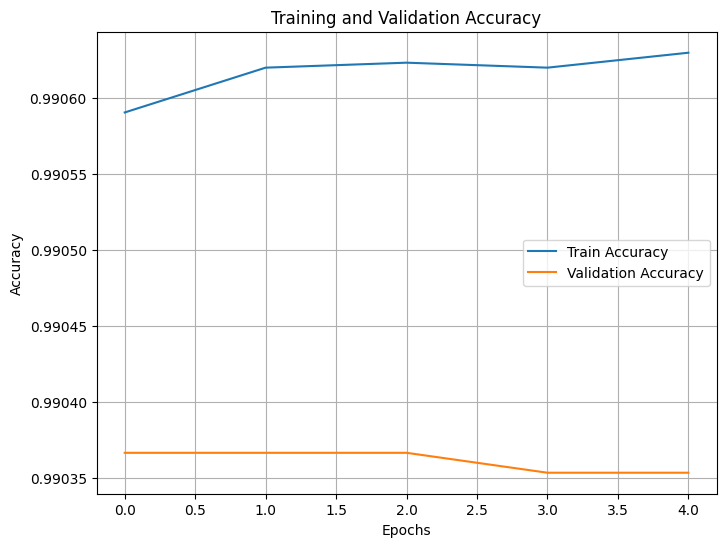

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# from collections import Counter
# print("Training Set Label Distribution:", Counter(Y_train.flatten()))
# print("Validation Set Label Distribution:", Counter(Y_val.flatten()))

## STEP 3: LSTM

In [29]:
K.clear_session()
tf.config.experimental.reset_memory_stats('/GPU:0')

In [30]:
from tensorflow.keras.layers import Bidirectional, Attention
max_len = 49 
# vocab_size = 5000  

class DataGenerator(Sequence):
    def __init__(self, X, Y, batch_size, max_len):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.max_len = max_len
        self.indices = np.arange(len(self.X))  

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = start + self.batch_size
        batch_indices = self.indices[start:end].astype(int)

        X_batch = [self.X[i] for i in batch_indices]
        Y_batch = [self.Y[i] for i in batch_indices]

        X_batch = pad_sequences(X_batch, maxlen=self.max_len, padding='post')
        Y_batch = pad_sequences(Y_batch, maxlen=self.max_len, padding='post')

        return np.array(X_batch), np.array(Y_batch)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)


X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Generator configuration
batch_size = 128
train_generator = DataGenerator(X_train, Y_train, batch_size, max_len)
val_generator = DataGenerator(X_val, Y_val, batch_size, max_len)

# Model construction
embedding_size = 128 # Embedding layer dimension
hidden_size1 = 128  # Hidden layer size for the first LSTM
hidden_size2 = 64   # Hidden layer size for the second LSTM

inp = Input(shape=(max_len,))
x = Embedding(input_dim=vocab_size, output_dim=embedding_size, mask_zero=True)(inp)
x = LSTM(hidden_size1, return_sequences=True)(x)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(hidden_size2, return_sequences=True))(x)
outputs = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs=inp, outputs=outputs)


# Define the model
# model = Model(inputs=inp, outputs=outputs)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

model.summary()

model.fit(train_generator, validation_data=val_generator, epochs=5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49)]              0         
                                                                 
 embedding (Embedding)       (None, 49, 128)           363904    
                                                                 
 lstm (LSTM)                 (None, 49, 128)           131584    
                                                                 
 dropout (Dropout)           (None, 49, 128)           0         
                                                                 
 bidirectional (Bidirection  (None, 49, 128)           98816     
 al)                                                             
                                                                 
 dense (Dense)               (None, 49, 2843)          366747    
                                                             

2024-12-09 22:08:13.379547: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_42/output/_24'


1090/1090 [==============================] - 64s 49ms/step - loss: nan - accuracy: 0.4570 - val_loss: nan - val_accuracy: 0.4559
Epoch 2/5
1090/1090 [==============================] - 30s 27ms/step - loss: nan - accuracy: 0.4570 - val_loss: nan - val_accuracy: 0.4559
Epoch 3/5
1090/1090 [==============================] - 30s 28ms/step - loss: nan - accuracy: 0.4570 - val_loss: nan - val_accuracy: 0.4559
Epoch 4/5
1090/1090 [==============================] - 29s 27ms/step - loss: nan - accuracy: 0.4570 - val_loss: nan - val_accuracy: 0.4559
Epoch 5/5
1090/1090 [==============================] - 29s 26ms/step - loss: nan - accuracy: 0.4570 - val_loss: nan - val_accuracy: 0.4559


In [31]:
poem_incomplete = '密****歇****根****湖*****'
poem_index = []  
poem_text = ''   

for i in range(len(poem_incomplete)):
    current_word = poem_incomplete[i]
    if current_word != '*':  
        index = tokenizer.word_index.get(current_word, 0)  
    else:
        x = np.expand_dims(poem_index, axis=0)  
        x = pad_sequences(x, maxlen=max_len, padding='post')  
        y = model.predict(x)[0, i]  
        y[0] = 0  
        index = np.argmax(y)  
        current_word = tokenizer.index_word.get(index, '')  
    
    poem_index.append(index)  
    poem_text += current_word  

print("Generated poem:")
print(poem_text[:5])
print(poem_text[5:10])
print(poem_text[10:15])
print(poem_text[15:20])

1/1 [==============================] - 0s 65ms/step
Generated poem:
密皎然皎然
皎然皎然歇
皎然皎然皎
然皎然根皎
